In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
os.chdir("../../") # set to instruct_time/script/
os.getcwd()

'/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/instruct_time/script'

In [2]:
def parse_median_bounds(cell):
    match = re.match(r"([-\d.]+)\s*\[\s*([-\d.]+),\s*([-\d.]+)\s*\]", str(cell))
    if match:
        median = float(match.group(1))
        lower = float(match.group(2))
        upper = float(match.group(3))
        return median, lower, upper
    return None, None, None


def get_w_evals(w: float, attr_suffix: str) -> pd.DataFrame:
    dataset_names = {
        'syn_gt': 'Synthetic w/ ground truth',
        'syn'   : 'Synthetic',
        'air'   : 'Air Quality',
        'nicu' : 'NICU Heart Rate'
    }

    dfs = []
    for k, nice_name in dataset_names.items():
        try:
            # --- load 4 result files -------------------------------------------------
            base   = f"{k}{attr_suffix}"
            it     = pd.read_csv(f"./VITAL/results/{base}/res_df_iqr{w}.csv")
            if attr_suffix != "_at":
                it_open= pd.read_csv(f"./VITAL/results/{base}_open/res_df_iqr{w}.csv")

            te_dir = "tedit_lite" if attr_suffix == '_at' else "tedit_lite_tx"
            te     = pd.read_csv(f"./{te_dir}/tedit_save/te/{k}/res_df_iqr.csv")
            tw     = pd.read_csv(f"./{te_dir}/tedit_save/tw/{k}/res_df_iqr.csv")

            # --- add model column ----------------------------------------------------
            it['Model']      = 'InstructTime'
            if attr_suffix != "_at":
                it_open['Model'] = 'InstructTime (open-vocab)'
            te['Model']      = 'TEdit'
            tw['Model']      = 'Time Weaver'
            if attr_suffix == "_at":
                res = pd.concat([it, te, tw], ignore_index=True)
            else:
                res = pd.concat([it, it_open, te, tw], ignore_index=True)

            # --- pull out median / lower / upper as separate rows --------------------
            q25, q50, q75 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
            metric_cols = [c for c in res.columns if c != 'Model']

            for col in metric_cols:
                med, lo, up = [], [], []
                for cell in res[col]:
                    m, l, u = parse_median_bounds(cell)
                    med.append(m); lo.append(l); up.append(u)
                q50[col], q25[col], q75[col] = med, lo, up

            for df, q in zip([q25, q50, q75], [25, 50, 75]):
                df['Model']     = res['Model']
                df['quantile']  = q

            out = pd.concat([q25, q50, q75], ignore_index=True)
            out['dataset'] = nice_name          # human-readable!
            dfs.append(out)

        except FileNotFoundError as err:          # capture the exception ⇢ err
            print(f"skip {k}: {err}")            # full message, e.g. “[Errno 2] …/file.csv: No such file or directory”
            continue

    big = pd.concat(dfs, ignore_index=True)
    big['w'] = w
    return big


def plot_metric(df: pd.DataFrame,
                metric: str,
                dot_models = ('InstructTime', 'InstructTime (open-vocab)'),
                line_models= ('TEdit', 'Time Weaver'),
                jitter     = 0.01,
                yscale     = 'linear',
                figsize    = (5,3)):
    """
    Draw one row of subplots (one per dataset) for the given metric.
    """
    datasets = df['dataset'].unique()
    n = len(datasets)
    fig, axs = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]), sharey=False)
    axs = axs if n > 1 else [axs]

    # jitter only for dot models
    jit = {m: jitter*(i-0.5) if m in dot_models else 0.0
           for i,m in enumerate(dot_models+line_models)}

    for i, dname in enumerate(datasets):
        ax   = axs[i]
        sub  = df[df['dataset']==dname]

        # pivot -> columns 25,50,75
        piv = (sub.pivot_table(index=['w','Model'], columns='quantile', values=metric)
                  .reset_index()
                  .rename(columns={25:'q25', 50:'q50', 75:'q75'})
                  .dropna(subset=['q50']))

        for model in piv['Model'].unique():
            mdat = piv[piv['Model']==model].sort_values('w')
            x    = mdat['w'] + jit.get(model,0)

            if model in line_models:
                ax.plot(mdat['w'], mdat['q50'], label=model, lw=1.6)
            else:
                ax.plot(mdat['w'], mdat['q50'], label=model, lw=1.2,
                        marker='o', ms=4, linestyle='-')   # dots + connecting line

        ax.set_xlabel('w')
        if i==0: ax.set_ylabel(metric)
        ax.set_title(dname)
        ax.set_xticks(sorted(sub['w'].unique()))      # ticks only at actual w’s
        ax.set_yscale(yscale)
        ax.grid(True, ls='--', lw=0.5)

    # legend outside on right
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left',
               bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.tight_layout(rect=[0,0,0.92,1])   # leave space for legend
    return fig, axs

In [3]:
w_dfs = []
for w in [0.5, 0.6, 0.7, 0.8, 0.9]:
    w_dfs.append(get_w_evals(w, '_at'))
w_df1 = pd.concat(w_dfs, axis=0, ignore_index=True)
w_df1['setting'] = 'Attribute-based'
w_dfs = []
for w in [0.5, 0.6, 0.7, 0.8, 0.9]:
    w_dfs.append(get_w_evals(w, ''))
w_df2 = pd.concat(w_dfs, axis=0, ignore_index=True)
w_df2['setting'] = 'Text-based'

w_df = pd.concat([w_df1, w_df2], axis=0, ignore_index=True)
w_df.to_csv("./VITAL/results/paper/w_df.csv", index=False)
# plot_metric(w_df, metric='RaTS ↑', yscale='linear')
# plot_metric(w_df, metric='DTW distance decrease ↓', jitter=0.015)


# case study

In [1]:
import os
os.chdir("../") # set to  VITAL

overwrite = False
dataset_name = 'syn_gt'
attr_suffix = ''
suffix = '_self' 

In [2]:
with open('run/settings.py', 'r') as file:
    exec(file.read())
with open('run/data.py', 'r') as file:
    exec(file.read())
with open('run/model.py', 'r') as file:
    exec(file.read())

Random seed set to 333
using device:  cpu
syn_gt_self
syn_gt_self


final distribution of text prediction
text
No trend. No seasonal pattern. No sharp shifts. The time series exhibits low variability.                                                                                                210
No trend. No seasonal pattern. No sharp shifts. The time series exhibits high variability.                                                                                               210
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts upwards. The time series exhibits low variability.          210
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts upwards. The time series exhibits high variability.         210
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts downward

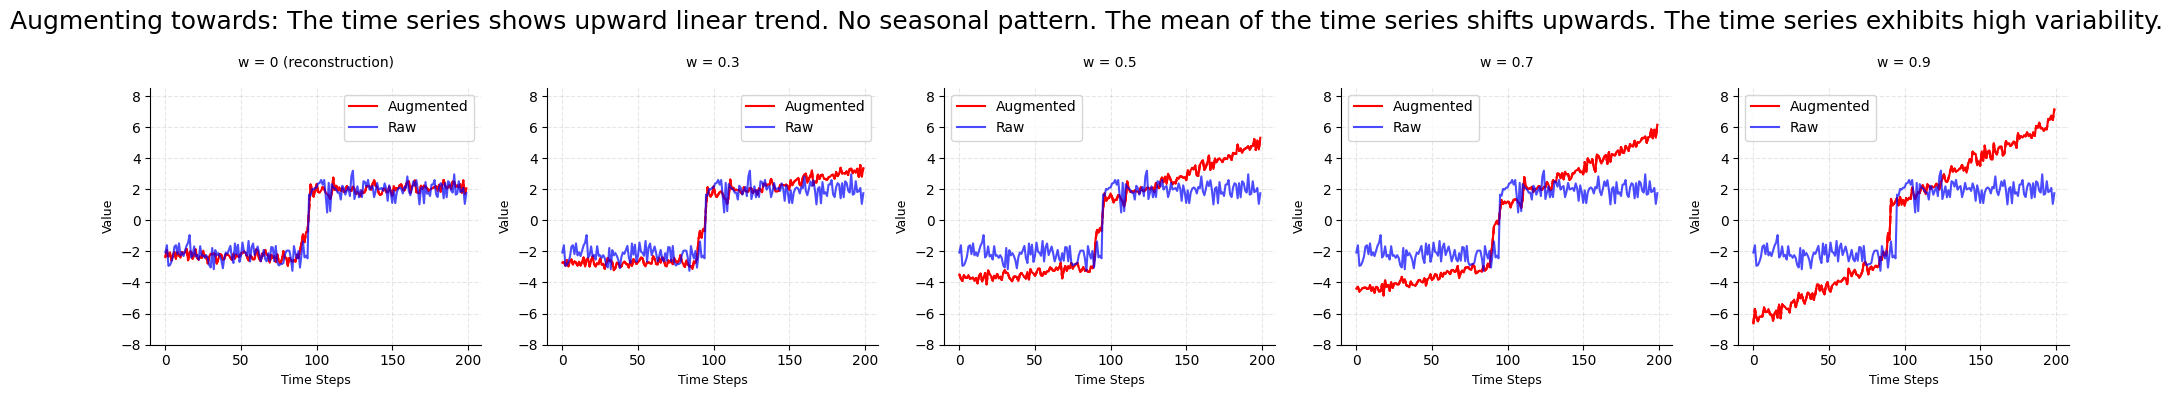

In [3]:

tid = 100
df = df_left

model.eval()

w_values = [0, 0.3, 0.5, 0.7, 0.9]
y_col = 'segment1'
ref_level = 'No trend.'
tgt_level = 'The time series shows upward linear trend.'

df_level = df[df[y_col] == ref_level].reset_index(drop=True).iloc[[tid]].copy()
df_level['new_text'] = df_level['text'].str.replace(ref_level, tgt_level)
essentials = plot_interpolate_ts_tx_ws_sampling(df_level, model, config_dict, text_cols=['new_text'], w_values = w_values, label = True, b=1, ep=1, ylims = None, return_essentials = True)



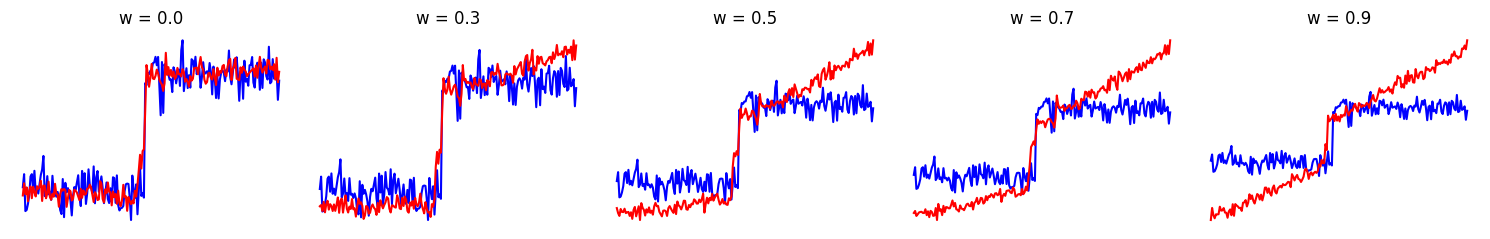

In [4]:
import matplotlib.pyplot as plt
import numpy as np

raw_ts   = essentials["raw_ts"]
medians  = essentials["median"]          # {text_cond: {w: median}}
w_values = essentials["w_values"]
text_cond = list(medians.keys())[0]      # use first text condition

# grid layout
n_cols = 5
n_rows = int(np.ceil(len(w_values) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5), squeeze=False)

for idx, w in enumerate(w_values):
    r, c = divmod(idx, n_cols)
    ax = axs[r, c]

    ax.plot(raw_ts,                       color="blue", label="raw")
    ax.plot(medians[text_cond][float(w)], color="red",  label="median")
    ax.set_title(f"w = {w}")
    ax.axis("off")                        # remove ticks & spines for simplicity

# hide unused panels
for idx in range(len(w_values), n_rows * n_cols):
    r, c = divmod(idx, n_cols)
    axs[r, c].axis("off")

plt.tight_layout()
plt.show()
